# **Ex8. 영화리뷰 텍스트 감성분석하기**

**루브릭 평가**

----

1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다. - 3가지 이상의 모델이 성공적으로 시도됨

2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다. - 
gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다. - 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함


# 1.데이터 불러오기 

In [ ]:
import os
# install konlpy, jdk, JPype
!pip install konlpy
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip3 install JPype1-py3

# install mecab-ko
os.chdir('/tmp/')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
!tar zxfv mecab-0.996-ko-0.9.2.tar.gz
os.chdir('/tmp/mecab-0.996-ko-0.9.2')
!./configure
!make
!make check
!make install

# install mecab-ko-dic
!apt-get install automake
os.chdir('/tmp')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz
!tar -zxvf mecab-ko-dic-2.1.1-20180720.tar.gz
os.chdir('/tmp/mecab-ko-dic-2.1.1-20180720')
!./autogen.sh
!./configure
!make
!make install

# install mecab-python
os.chdir('/content')
!git clone https://bitbucket.org/eunjeon/mecab-python-0.996.git
os.chdir('/content/mecab-python-0.996')
!python3 setup.py build
!python3 setup.py install

- Mecab 한글판을 사용하기 위한 모듈 다운로드

In [ ]:
# 환경 설정

import glob
import os
import re
import numpy as np
import pandas as pd
import konlpy

from collections import Counter

import urllib.request
from konlpy.tag import Okt, Mecab

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant

import gensim
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

from keras.layers import Bidirectional, LSTM, GRU, Dense, Conv1D
from keras.layers import Embedding, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

print(konlpy.__version__)
print(gensim.__version__)
# 훈련 데이터, 테스트 데이터 준비
# ~ 이 HOME
train_data = pd.read_table('/content/drive/MyDrive/exploration/Ex8/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/exploration/Ex8/ratings_test.txt')

0.6.0
3.6.0


In [ ]:
# 훈련 데이터 살펴보기
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
# 테스트 데이터 살펴보기
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


- label 값이 0이면 부정적, 1이면 긍정적 반응

# 2.데이터로더 구성

In [ ]:
# Mecab으로 토큰화하기

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [ ]:
# idx2wrd
index_to_word = {index:word for word, index in word_to_index.items()}

# 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개 문장 리스트 + 딕셔너리 = 인덱스로 변환
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 워드벡터 디코딩
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개 문장 디코딩
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

AttributeError: ignored

In [ ]:
print(len(X_train)) 
print(len(y_train)) 
print(len(X_test))
print(len(y_test))
print('word_to_index : ',len(word_to_index), type(word_to_index))

146182
146182
49157
49157


TypeError: ignored

In [ ]:
word_to_index

- 토큰 index 확인

In [ ]:
word_to_index["<PAD>"] = 0  # 패딩
word_to_index["<BOS>"] = 1  # 모든 문장의 시작
word_to_index["<UNK>"] = 2  # Unknown을 의미

In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면 단어 인덱스 리스트 벡터로 변환해 주는 함수 
# 모든 문장은 <BOS>로 시작하도록 설정
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode해 주는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3.데이터 가공

In [ ]:
total_text_len = list(X_train) + list(X_test)

# 텍스트데이터 문장 길이 리스트 생성
num_tokens = [len(tokens) for tokens in total_text_len]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차 계산
print('평균: ', np.mean(num_tokens))
print('최대값: ', np.max(num_tokens))
print('표준편차: ', np.std(num_tokens))

# 최대 길이 = 평균 + 표준편차*2
maxlen = int(np.mean(num_tokens) + np.std(num_tokens)*2)

print('최대길이: ', maxlen)
print('전체 문장의 {}%가 포함됨'.format(round(np.sum(num_tokens < maxlen)/len(num_tokens)*100, 3)))

평균:  15.969376315021577
최대값:  116
표준편차:  12.843535456326455
최대길이:  41
전체 문장의 93.065%가 포함됨


In [ ]:
# RNN 모델에 맞게 pre 옵션으로 패딩
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                      value=word_to_index['<PAD>'],
                                                      padding='pre',
                                                      maxlen=maxlen)
print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


# 4.학습모델, validation 설정

In [ ]:
#RNN모델
# 단어사전
vocab_size = 10000

# 워드임베딩 벡터
word_vec_dim = 16

# relu, sigmoid RNN
model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Embedding(vocab_size, word_vec_dim, input_shape=(None,)))
model_rnn.add(tf.keras.layers.LSTM(8))
model_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 16)          160000    
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dense_6 (Dense)             (None, 8)                 72        
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# CNN 모델
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vec_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 16)          160000    
                                                                 
 conv1d_2 (Conv1D)           (None, None, 16)          1808      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 8)                

In [ ]:
# Global Maxpooling 모델
model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vec_dim, input_shape=(None,)))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_gmp.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_max_pooling1d_3 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [ ]:
partial_x, x_val, partial_y, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=17)

# 5.모델 학습과 시각화

In [ ]:
# visualization Loss & Accuracy by epochs
def visualization(history):
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    
    # Loss
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.clf()
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# model을 훈련시키고 평가해보는 함수
def fitting_machine(model,epoch):
    # model compile
    model = model
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    # model training and recording history
    history = model.fit(partial_x,
                        partial_y,
                        epochs=epoch,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)
    # print result
    results = model.evaluate(X_test,  y_test, verbose=2)
    print(f'\nThis is {model.name}\nLoss: {results[0]}\nAccurancy: {results[1]}\n')
    
    return history

In [ ]:
# RNN
rnn_history = fitting_machine(model_rnn, 5)

Epoch 1/5
229/229 [==============================] - 3s 8ms/step - loss: 0.4950 - accuracy: 0.7847 - val_loss: 0.3758 - val_accuracy: 0.8396
Epoch 2/5
229/229 [==============================] - 1s 6ms/step - loss: 0.3416 - accuracy: 0.8571 - val_loss: 0.3598 - val_accuracy: 0.8444
Epoch 3/5
229/229 [==============================] - 1s 6ms/step - loss: 0.3179 - accuracy: 0.8687 - val_loss: 0.3572 - val_accuracy: 0.8452
Epoch 4/5
229/229 [==============================] - 1s 6ms/step - loss: 0.3056 - accuracy: 0.8741 - val_loss: 0.3581 - val_accuracy: 0.8453
Epoch 5/5
229/229 [==============================] - 2s 7ms/step - loss: 0.2963 - accuracy: 0.8777 - val_loss: 0.3588 - val_accuracy: 0.8456
1537/1537 - 4s - loss: 0.3579 - accuracy: 0.8453 - 4s/epoch - 2ms/step

This is sequential_3
Loss: 0.3578675091266632
Accurancy: 0.8452916145324707



In [ ]:
# CNN
cnn_history = fitting_machine(model_cnn, 5)

Epoch 1/5
229/229 [==============================] - 2s 6ms/step - loss: 0.5080 - accuracy: 0.7437 - val_loss: 0.3673 - val_accuracy: 0.8395
Epoch 2/5
229/229 [==============================] - 1s 5ms/step - loss: 0.3301 - accuracy: 0.8594 - val_loss: 0.3522 - val_accuracy: 0.8468
Epoch 3/5
229/229 [==============================] - 1s 5ms/step - loss: 0.2962 - accuracy: 0.8770 - val_loss: 0.3481 - val_accuracy: 0.8495
Epoch 4/5
229/229 [==============================] - 1s 5ms/step - loss: 0.2687 - accuracy: 0.8913 - val_loss: 0.3583 - val_accuracy: 0.8476
Epoch 5/5
229/229 [==============================] - 1s 5ms/step - loss: 0.2405 - accuracy: 0.9047 - val_loss: 0.3624 - val_accuracy: 0.8510
1537/1537 - 3s - loss: 0.3632 - accuracy: 0.8502 - 3s/epoch - 2ms/step

This is sequential_4
Loss: 0.36317139863967896
Accurancy: 0.8502349853515625



In [ ]:
# Global Maxpooling
gmp_history = fitting_machine(model_gmp, 5)

Epoch 1/5
229/229 [==============================] - 1s 4ms/step - loss: 0.5954 - accuracy: 0.7506 - val_loss: 0.4459 - val_accuracy: 0.8114
Epoch 2/5
229/229 [==============================] - 1s 4ms/step - loss: 0.3853 - accuracy: 0.8335 - val_loss: 0.3769 - val_accuracy: 0.8339
Epoch 3/5
229/229 [==============================] - 1s 4ms/step - loss: 0.3343 - accuracy: 0.8576 - val_loss: 0.3660 - val_accuracy: 0.8393
Epoch 4/5
229/229 [==============================] - 1s 4ms/step - loss: 0.3077 - accuracy: 0.8708 - val_loss: 0.3656 - val_accuracy: 0.8396
Epoch 5/5
229/229 [==============================] - 1s 4ms/step - loss: 0.2883 - accuracy: 0.8806 - val_loss: 0.3690 - val_accuracy: 0.8402
1537/1537 - 2s - loss: 0.3697 - accuracy: 0.8380 - 2s/epoch - 2ms/step

This is sequential_5
Loss: 0.3696741461753845
Accurancy: 0.8379681706428528



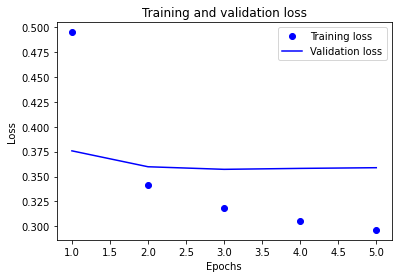

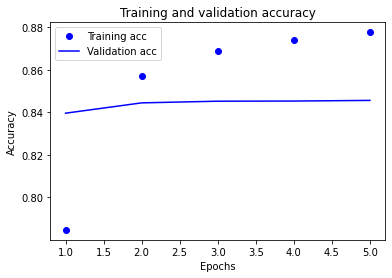

In [ ]:
# rnn
visualization(rnn_history)

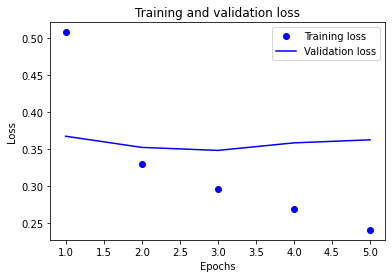

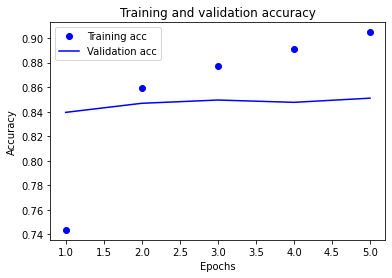

In [ ]:
visualization(cnn_history)

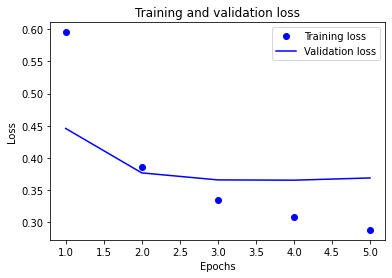

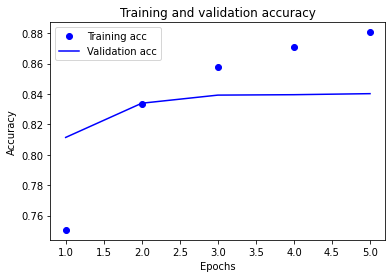

In [ ]:
visualization(gmp_history)

# RNN

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

embedding_layer = model_rnn.layers[0]
weights = embedding_layer.get_weights()[0]
vocab_size, word_vector_dim = weights.shape[0], weights.shape[1]

word2vec_file_path = '/content/drive/MyDrive/exploration/Ex8/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_rnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.05880253, -0.00975633, -0.04509036, -0.05033837, -0.00593232,
       -0.05815073,  0.05004425,  0.07996732,  0.06578143,  0.02422018,
        0.01547838,  0.0517291 ,  0.00822471,  0.02263253, -0.01636472,
        0.01100137], dtype=float32)

In [ ]:
word_vectors.similar_by_word('사랑')

[('걸작', 0.9598358869552612),
 ('미소', 0.9557639956474304),
 ('베이더', 0.9528648853302002),
 ('어울려요', 0.9523595571517944),
 ('요런', 0.9515356421470642),
 ('올림', 0.948522686958313),
 ('9', 0.9474233388900757),
 ('^^♥', 0.9459345936775208),
 ('따뜻', 0.9457799196243286),
 ('ㅠㅠㅠㅠ', 0.9452619552612305)]

In [ ]:
word_vectors.similar_by_word('최고')

[('테일러', 0.9855296611785889),
 ('곱씹', 0.9853688478469849),
 ('되돌아보', 0.9850332736968994),
 ('달달', 0.9846851229667664),
 ('love', 0.9820016622543335),
 ('외우', 0.9815325736999512),
 ('빠져드', 0.981306791305542),
 ('쿵', 0.9799346923828125),
 ('매트릭스', 0.9795199632644653),
 ('모건', 0.9793590307235718)]

In [ ]:
word_vectors.similar_by_word('실망')

[('베끼', 0.9907784461975098),
 ('눈살', 0.9905377626419067),
 ('선동', 0.9892390370368958),
 ('맛없', 0.988705575466156),
 ('짝퉁', 0.9871876239776611),
 ('아까웠', 0.9861903786659241),
 ('신파', 0.9860045909881592),
 ('늘어진다', 0.985871434211731),
 ('불면증', 0.9857812523841858),
 ('그라', 0.9857176542282104)]

In [ ]:
word_vectors.similar_by_word('감동')

[('집니다', 0.9527807235717773),
 ('듭니다', 0.9474495649337769),
 ('한텐', 0.9467990398406982),
 ('갑', 0.9458689093589783),
 ('조니뎁', 0.9450272917747498),
 ('^^♥', 0.9422000646591187),
 ('높여', 0.9384574890136719),
 ('어염', 0.9364267587661743),
 ('꼽히', 0.9359285831451416),
 ('쩐', 0.933407187461853)]

- 조금 아쉽지만 어느정도 납득이 가는 부분이 있긴하다.

# CNN

In [ ]:
embedding_layer = model_cnn.layers[0]
weights = embedding_layer.get_weights()[0]
vocab_size, word_vector_dim = weights.shape[0], weights.shape[1]

word2vec_file_path = '/content/drive/MyDrive/exploration/Ex8/word2vec.txt'
f2 = open(word2vec_file_path, 'w')
f2.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_cnn.get_weights()[0]
for i in range(4,vocab_size):
    f2.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f2.close()

word_vectors2 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector2 = word_vectors2['컴퓨터']
vector2

array([-0.04354319,  0.06153209, -0.14624107, -0.02067504,  0.00397056,
        0.05293054, -0.07103912, -0.02722322,  0.0774714 ,  0.04940563,
        0.03602645, -0.04261161, -0.03091254, -0.03310879, -0.03603431,
       -0.09346683], dtype=float32)

In [ ]:
word_vectors2.similar_by_word('사랑')

[('위력', 0.9366095066070557),
 ('am', 0.9117095470428467),
 ('본방', 0.9088447690010071),
 ('감탄사', 0.9085747003555298),
 ('힐링', 0.906576931476593),
 ('아름다우', 0.9025333523750305),
 ('젊', 0.9009824991226196),
 ('맑', 0.9001326560974121),
 ('일품', 0.8985932469367981),
 ('very', 0.8970806002616882)]

In [ ]:
word_vectors2.similar_by_word('최고')

[('나무랄', 0.9613500237464905),
 ('발킬머', 0.960889458656311),
 ('하모니', 0.9599438309669495),
 ('놀라웠', 0.9574078321456909),
 ('괜춘', 0.957161009311676),
 ('쌤', 0.9564313888549805),
 ('찡하', 0.9557209014892578),
 ('감독판', 0.9542120695114136),
 ('졸이', 0.953821063041687),
 ('호프만', 0.9531809091567993)]

In [ ]:
word_vectors2.similar_by_word('실망')

[('재탕', 0.9577193260192871),
 ('기영화', 0.9497253894805908),
 ('피곤', 0.9487301707267761),
 ('별로', 0.9342886805534363),
 ('더러워', 0.9308969378471375),
 ('당혹', 0.9255508780479431),
 ('지못미', 0.9237115979194641),
 ('뻔해서', 0.9236860275268555),
 ('유도', 0.9232006669044495),
 ('먹칠', 0.9197146892547607)]

In [ ]:
word_vectors2.similar_by_word('감동')

[('깨닫', 0.9040153622627258),
 ('탁월', 0.8856406211853027),
 ('폴', 0.8841241598129272),
 ('살아갈', 0.8811447620391846),
 ('간지', 0.8805170655250549),
 ('사로잡', 0.8800039887428284),
 ('달랐', 0.8750413656234741),
 ('더락', 0.8733901977539062),
 ('매혹', 0.8713136911392212),
 ('위대', 0.8710557818412781)]

- 얘는 약간 문장이 끊겨서 출력되는 느낌이다.

# Global Maxpooling

In [ ]:
embedding_layer = model_gmp.layers[0]
weights = embedding_layer.get_weights()[0]
vocab_size, word_vector_dim = weights.shape[0], weights.shape[1]

word2vec_file_path = '/content/drive/MyDrive/exploration/Ex8/word2vec.txt'
f3 = open(word2vec_file_path, 'w')
f3.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_gmp.get_weights()[0]
for i in range(4,vocab_size):
    f3.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f3.close()

word_vectors3 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector3 = word_vectors3['컴퓨터']
vector3

array([-0.08692946,  0.0403352 , -0.00061484,  0.01379084, -0.08932009,
        0.00768522, -0.04868272, -0.04235793, -0.09264401, -0.03787342,
       -0.0331058 , -0.05115375, -0.06665156, -0.08725067,  0.01705205,
        0.02507496], dtype=float32)

In [ ]:
word_vectors3.similar_by_word('사랑')

[('다룬', 0.9610794186592102),
 ('콜린', 0.9495394825935364),
 ('꽤', 0.9485722780227661),
 ('제주', 0.939071774482727),
 ('부담없이', 0.9390106201171875),
 ('느와르', 0.9340960383415222),
 ('!♥', 0.9337279796600342),
 ('명작', 0.9336435794830322),
 ('산다는', 0.9319370985031128),
 ('홍금보', 0.9318886995315552)]

In [ ]:
word_vectors3.similar_by_word('최고')

[('그려냈', 0.9060783386230469),
 ('미묘', 0.9036746025085449),
 ('연민', 0.9009443521499634),
 ('따스', 0.8972414135932922),
 ('작살', 0.893101155757904),
 ('요세', 0.8835309743881226),
 ('멋지', 0.8827212452888489),
 ('이제서야', 0.8814734816551208),
 ('은대', 0.8809100389480591),
 ('백미', 0.8793767094612122)]

In [ ]:
word_vectors3.similar_by_word('실망')

[('흑인', 0.8890486359596252),
 ('어째', 0.8841453790664673),
 ('고갈', 0.8679172992706299),
 ('미화', 0.8457769751548767),
 ('으려는', 0.8452491164207458),
 ('...?', 0.8451630473136902),
 ('아휴', 0.8412999510765076),
 ('개구리', 0.8361984491348267),
 ('흔히', 0.8330844640731812),
 ('욕했', 0.8281581401824951)]

In [ ]:
word_vectors3.similar_by_word('감동')

[('기쁨', 0.9598735570907593),
 ('이분', 0.9458004236221313),
 ('괜찮', 0.9442037343978882),
 ('메인', 0.9393804669380188),
 ('셔요', 0.9378529787063599),
 ('패션', 0.9375036954879761),
 ('두근두근', 0.9327843189239502),
 ('베스트', 0.9314578771591187),
 ('~!!', 0.9293482303619385),
 ('ost', 0.9282374978065491)]

- CNN과 RNN의 요소가 섞여서 출력이 된 것 같다.

- 결과적으로 가장 만족스러운 결과가 RNN이었다.

# 6.Word 2 Vector

In [ ]:
word2vec_path = '/content/drive/MyDrive/exploration/Ex8/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['컴퓨터']
vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([-1.517628  , -0.8935504 , -1.4352998 ,  1.5069847 , -1.5178334 ,
        1.1542678 , -2.94064   ,  1.1850045 ,  0.19959009, -1.5288961 ,
       -1.7067502 , -2.1892095 , -0.20728938, -2.2606812 , -2.2283888 ,
        0.32318738, -0.2845471 , -0.07731772, -0.86269003, -1.1722927 ,
       -0.91062415,  0.8440715 ,  0.903278  , -0.84685427,  0.7023384 ,
       -2.1920419 , -0.47571626, -0.60159504, -0.68860835,  0.18944737,
        0.5319404 ,  0.73058116, -0.9658133 , -1.0123725 , -0.36183038,
        2.5851305 ,  0.66589296, -1.7231252 ,  1.7576753 ,  0.88845277,
        1.5791365 , -4.430691  ,  0.36731872,  0.69481534, -0.46041563,
        1.742655  , -1.5077016 ,  0.72209424, -0.04532204, -0.6557301 ,
       -0.71276623,  0.26522732, -0.17656395, -2.4720876 , -0.845565  ,
        0.23591152,  1.3414925 ,  0.77577615, -2.289371  , -0.8078124 ,
        1.4359473 ,  0.22882733, -1.08867   ,  1.2607764 , -1.7469797 ,
        0.06542054,  0.39896825, -0.3160832 , -1.7257563 ,  0.54

In [ ]:
word2vec.similar_by_word('감동')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('감명', 0.7177015542984009),
 ('감격', 0.6908231973648071),
 ('실망', 0.6267645359039307),
 ('감화', 0.6191877126693726),
 ('감탄', 0.6140128374099731),
 ('칭찬', 0.6059398055076599),
 ('존경', 0.6032299995422363),
 ('자극', 0.594598650932312),
 ('감복', 0.5902734994888306),
 ('호응', 0.5850393772125244)]

In [ ]:
word2vec.similar_by_word('최고')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('최대', 0.5721614360809326),
 ('최강', 0.5064552426338196),
 ('유일한', 0.46688494086265564),
 ('일류', 0.46184951066970825),
 ('최악', 0.4529539942741394),
 ('최연소', 0.45037323236465454),
 ('랭킹', 0.4485436677932739),
 ('제일의', 0.44647401571273804),
 ('최초', 0.44505739212036133),
 ('최상', 0.4345606565475464)]

In [ ]:
vector.shape #dim 200

(200,)

In [ ]:
# 단어사전
vocab_size = 10000

# 워드임베딩 벡터
word_vec_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vec_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 순서대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [ ]:
embedding_matrix.shape

(10000, 200)

In [ ]:
# RNN_new
new_rnn = tf.keras.Sequential()
new_rnn.add(tf.keras.layers.Embedding(vocab_size, word_vec_dim,
                                      embeddings_initializer=Constant(embedding_matrix),
                                      input_length=maxlen,
                                      trainable=True))
new_rnn.add(tf.keras.layers.LSTM(8))
new_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
new_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

new_rnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 lstm_2 (LSTM)               (None, 8)                 6688      
                                                                 
 dense_12 (Dense)            (None, 8)                 72        
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# CNN_new
new_cnn = tf.keras.Sequential()
new_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vec_dim,
                                      embeddings_initializer=Constant(embedding_matrix),
                                      input_length=maxlen,
                                      trainable=True))
new_cnn.add(tf.keras.layers.LSTM(8))
new_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
new_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

new_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 lstm_3 (LSTM)               (None, 8)                 6688      
                                                                 
 dense_14 (Dense)            (None, 8)                 72        
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Global Maxplling_new
new_gmp = tf.keras.Sequential()
new_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vec_dim,
                                      embeddings_initializer=Constant(embedding_matrix),
                                      input_length=maxlen,
                                      trainable=True))
new_gmp.add(tf.keras.layers.LSTM(8))
new_gmp.add(tf.keras.layers.Dense(8, activation='relu'))
new_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))

new_gmp.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 lstm_4 (LSTM)               (None, 8)                 6688      
                                                                 
 dense_16 (Dense)            (None, 8)                 72        
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


# 7.재학습

In [ ]:
# RNN
new_rnn_hist = fitting_machine(new_rnn, 5)

Epoch 1/5
229/229 [==============================] - 4s 9ms/step - loss: 0.2384 - accuracy: 0.9064 - val_loss: 0.3765 - val_accuracy: 0.8485
Epoch 2/5
229/229 [==============================] - 2s 7ms/step - loss: 0.2269 - accuracy: 0.9116 - val_loss: 0.3783 - val_accuracy: 0.8495
Epoch 3/5
229/229 [==============================] - 2s 7ms/step - loss: 0.2162 - accuracy: 0.9159 - val_loss: 0.3874 - val_accuracy: 0.8498
Epoch 4/5
229/229 [==============================] - 2s 7ms/step - loss: 0.2065 - accuracy: 0.9209 - val_loss: 0.3995 - val_accuracy: 0.8479
Epoch 5/5
229/229 [==============================] - 2s 7ms/step - loss: 0.1972 - accuracy: 0.9258 - val_loss: 0.4160 - val_accuracy: 0.8391
1537/1537 - 4s - loss: 0.4079 - accuracy: 0.8434 - 4s/epoch - 2ms/step

This is sequential_6
Loss: 0.4079018831253052
Accurancy: 0.843399703502655



In [ ]:
# CNN
new_cnn_hist = fitting_machine(new_cnn, 5)

Epoch 1/5
229/229 [==============================] - 4s 9ms/step - loss: 0.5291 - accuracy: 0.7315 - val_loss: 0.4170 - val_accuracy: 0.8152
Epoch 2/5
229/229 [==============================] - 2s 7ms/step - loss: 0.3685 - accuracy: 0.8406 - val_loss: 0.3763 - val_accuracy: 0.8344
Epoch 3/5
229/229 [==============================] - 2s 8ms/step - loss: 0.3251 - accuracy: 0.8638 - val_loss: 0.3651 - val_accuracy: 0.8422
Epoch 4/5
229/229 [==============================] - 2s 7ms/step - loss: 0.2994 - accuracy: 0.8763 - val_loss: 0.3625 - val_accuracy: 0.8464
Epoch 5/5
229/229 [==============================] - 2s 8ms/step - loss: 0.2828 - accuracy: 0.8839 - val_loss: 0.3595 - val_accuracy: 0.8481
1537/1537 - 4s - loss: 0.3572 - accuracy: 0.8487 - 4s/epoch - 3ms/step

This is sequential_7
Loss: 0.35719946026802063
Accurancy: 0.8487499356269836



In [ ]:
# Global Maxpooling
new_gmp_hist = fitting_machine(new_gmp, 5)

Epoch 1/5
229/229 [==============================] - 4s 9ms/step - loss: 0.5342 - accuracy: 0.7251 - val_loss: 0.4097 - val_accuracy: 0.8180
Epoch 2/5
229/229 [==============================] - 2s 7ms/step - loss: 0.3644 - accuracy: 0.8437 - val_loss: 0.3756 - val_accuracy: 0.8356
Epoch 3/5
229/229 [==============================] - 2s 7ms/step - loss: 0.3223 - accuracy: 0.8646 - val_loss: 0.3587 - val_accuracy: 0.8457
Epoch 4/5
229/229 [==============================] - 2s 7ms/step - loss: 0.2990 - accuracy: 0.8764 - val_loss: 0.3585 - val_accuracy: 0.8477
Epoch 5/5
229/229 [==============================] - 2s 7ms/step - loss: 0.2812 - accuracy: 0.8845 - val_loss: 0.3580 - val_accuracy: 0.8481
1537/1537 - 4s - loss: 0.3569 - accuracy: 0.8493 - 4s/epoch - 2ms/step

This is sequential_8
Loss: 0.3568824827671051
Accurancy: 0.8492584824562073



# 8.재학습의 재학습

In [ ]:
def fitting_machine2(model,epoch):
    # model compile
    model = model
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    # model training and recording history
    history = model.fit(partial_x,
                        partial_y,
                        epochs=epoch,
                        batch_size=32,
                        validation_data=(x_val, y_val),
                        verbose=1)
    # print result
    results = model.evaluate(X_test,  y_test, verbose=2)
    print(f'\nThis is {model.name}\nLoss: {results[0]}\nAccurancy: {results[1]}\n')
    
    return history

In [ ]:
# RNN_new2
new_rnn2 = tf.keras.Sequential()
new_rnn2.add(tf.keras.layers.Embedding(vocab_size, word_vec_dim,
                                      embeddings_initializer=Constant(embedding_matrix),
                                      input_length=maxlen,
                                      trainable=True))
new_rnn2.add(tf.keras.layers.LSTM(16))
new_rnn2.add(tf.keras.layers.Dense(8, activation='relu'))
new_rnn2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

new_rnn2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 lstm_5 (LSTM)               (None, 16)                13888     
                                                                 
 dense_18 (Dense)            (None, 8)                 136       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,014,033
Trainable params: 2,014,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# rnn2
new_rnn_hist2 = fitting_machine2(new_rnn2, 5)

Epoch 1/5
3655/3655 [==============================] - 23s 6ms/step - loss: 0.4074 - accuracy: 0.8118 - val_loss: 0.3565 - val_accuracy: 0.8427
Epoch 2/5
3655/3655 [==============================] - 23s 6ms/step - loss: 0.3122 - accuracy: 0.8669 - val_loss: 0.3415 - val_accuracy: 0.8528
Epoch 3/5
3655/3655 [==============================] - 21s 6ms/step - loss: 0.2758 - accuracy: 0.8843 - val_loss: 0.3394 - val_accuracy: 0.8556
Epoch 4/5
3655/3655 [==============================] - 21s 6ms/step - loss: 0.2457 - accuracy: 0.8980 - val_loss: 0.3486 - val_accuracy: 0.8533
Epoch 5/5
3655/3655 [==============================] - 22s 6ms/step - loss: 0.2187 - accuracy: 0.9107 - val_loss: 0.3633 - val_accuracy: 0.8527
1537/1537 - 4s - loss: 0.3629 - accuracy: 0.8531 - 4s/epoch - 2ms/step

This is sequential_9
Loss: 0.36291220784187317
Accurancy: 0.853123664855957



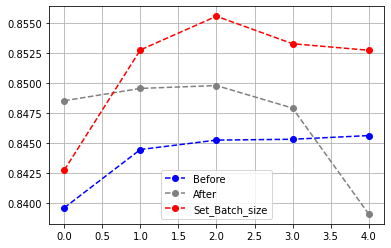

In [ ]:
plt.plot(rnn_history.history['val_accuracy'], '--o', color='blue', label='Before') # word2vector 전
plt.plot(new_rnn_hist.history['val_accuracy'], '--o', color='gray', label='After') # word2vector 후
plt.plot(new_rnn_hist2.history['val_accuracy'], '--o', color='red', label='Set_Batch_size') # word2vector 후(batch size 조정)
plt.legend()
plt.grid()

# 회고

---

- CNN과 RNN 그리고 Global maxpooling 모델 구현에 성공을 하였고, 각 모델 별로 유사단어 또한 비교할 수 있었다. 마지막으로 학습을 통하여 85.3%의 정확도도 달성하였다.